Code from:
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
How to Develop a GAN to Generate CIFAR10 Small Color Photographs
by Jason Brownlee on July 1, 2019 in Generative Adversarial Networks

and from
https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

How to Develop a CNN From Scratch for CIFAR-10 Photo Classification
by Jason Brownlee on May 13, 2019 in Deep Learning for Computer Vision

In [1]:
!pip install tensorflow==2.10.0
!pip install keras==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

In [35]:
from google.colab import files
from keras.models import load_model

uploaded = files.upload()

g_model = load_model('generator_model_200.h5')
#cifar10_model = load_model('final_model.h5')


Saving generator_model_200.h5 to generator_model_200 (3).h5


In [36]:
from google.colab import files
from keras.models import load_model

uploaded = files.upload()

#g_model = load_model('generator_model_200.h5')
cifar10_model = load_model('final_model.h5')


Saving final_model.h5 to final_model (1).h5


In [37]:
from keras.models import load_model

# Load the pre-trained GAN generator model
g_model = load_model('generator_model_200.h5')

# Load the pre-trained CIFAR-10 classification model
cifar10_model = load_model('final_model.h5')




In [38]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			if (j+1) % 50 == 0:
				print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
					(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [39]:
# size of the latent space
latent_dim = 128
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
#train(g_model, d_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 1s 259ms/step


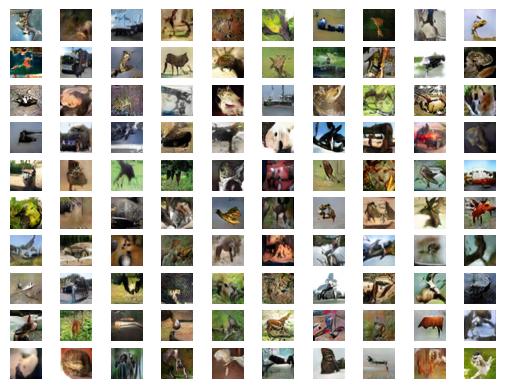

[[-0.12838258]]


In [40]:
# Generation of 100 fake pictures
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_200.h5')
#model = load_model('generator_model_050.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)
print(generate_latent_points(1, 1))

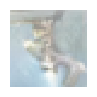

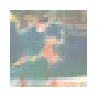

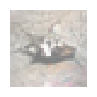

In [41]:
import matplotlib.pyplot as pyplot

# Rescale images to [0, 1] for proper display
image_1 = (X[0, :, :] + 1) / 2.0
image_2 = (X[10, :, :] + 1) / 2.0
image_3 = (X[20, :, :] + 1) / 2.0

# Plot the first image with nearest interpolation (no smoothing) and correct size
pyplot.figure(figsize=(1, 1))
pyplot.imshow(image_1, interpolation='nearest')
pyplot.axis('off')  # Hide the axes for better presentation
pyplot.show()

# Plot the second image
pyplot.figure(figsize=(1, 1))
pyplot.imshow(image_2, interpolation='nearest')
pyplot.axis('off')
pyplot.show()

# Plot the third image
pyplot.figure(figsize=(1, 1))
pyplot.imshow(image_3, interpolation='nearest')
pyplot.axis('off')
pyplot.show()


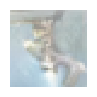

In [42]:
import matplotlib.pyplot as plt
# Rescale images to [0, 1] for proper display
image = (X[0, :, :] + 1) / 2.0

# Plot the image with nearest interpolation and check the figure size
plt.figure(figsize=(1, 1))  # Close to the original image size
plt.imshow(image, interpolation='nearest')  # Prevent smoothing with nearest interpolation
plt.axis('off')  # Turn off axis for better visualization
plt.show()


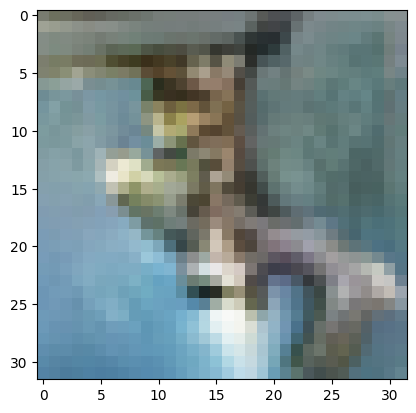

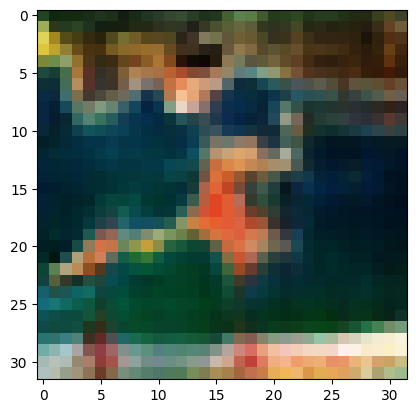

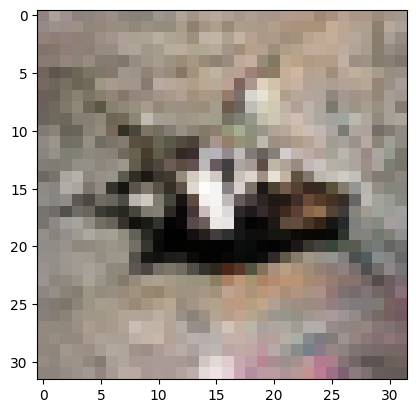

In [43]:
#Example of plotting the first image of the first three rows, one by one
#plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()
pyplot.imshow(X[10, :, :])
pyplot.show()
pyplot.imshow(X[20, :, :])
pyplot.show()




In [44]:
from keras.models import load_model
# We fit a CIFAR10 CNN classification model and save the final model to a file
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# load train and test dataset
#def load_dataset():
 # load dataset
 #(trainX, trainY), (testX, testY) = cifar10.load_data()
 # one hot encode target values
 #trainY = to_categorical(trainY)
 #testY = to_categorical(testY)
 #return trainX, trainY, testX, testY

# scale pixels
#def prep_pixels(train, test):
 # convert from integers to floats
 #train_norm = train.astype('float32')
 #test_norm = test.astype('float32')
  #normalize to range 0-1
 #train_norm = train_norm / 255.0
 #test_norm = test_norm / 255.0
 # return normalized images
 #return train_norm, test_norm

# define cnn model
#def define_model():
 #model = Sequential()
 #model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
 #model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 #model.add(MaxPooling2D((2, 2)))
 #model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 ##model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 #model.add(MaxPooling2D((2, 2)))
 #model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 #model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 #model.add(MaxPooling2D((2, 2)))
 #model.add(Flatten())
 #model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 #model.add(Dense(10, activation='softmax'))
 # compile model
 #opt = SGD(lr=0.001, momentum=0.9)
 #model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 #return model

# run the test harness for evaluating a model
#def run_test_harness():
 # load dataset
 #trainX, trainY, testX, testY = load_dataset()
 # prepare pixel data
 #trainX, testX = prep_pixels(trainX, testX)
 # define model
 #model = define_model()
 # fit model
 #model.fit(trainX, trainY, epochs=100, batch_size=64, verbose=1)
 # save model
 #model.save('final_model.h5')

# entry point, run the test harness
#run_test_harness()
cifar10_model = load_model('final_model.h5')

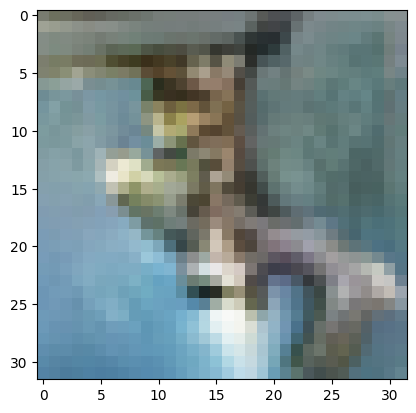

1/1 [==============================] - 0s 107ms/step
[[5.9072237e-16 1.0221599e-25 7.0785604e-09 1.0000000e+00 4.0833465e-09
  1.8224761e-09 1.9240198e-12 1.4200719e-16 2.4801803e-18 7.1890030e-24]]
1/1 [==============================] - 0s 21ms/step
Cat


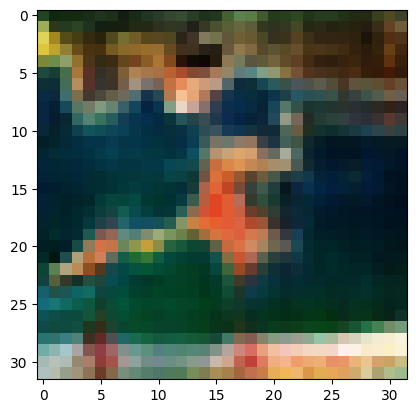

1/1 [==============================] - 0s 23ms/step
Bird


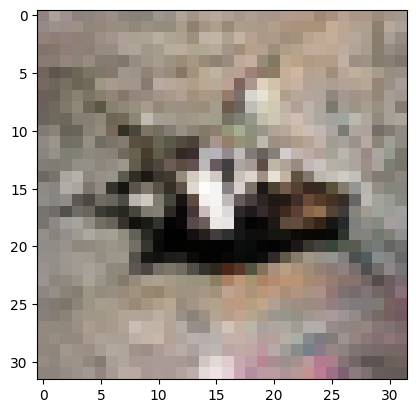

1/1 [==============================] - 0s 24ms/step
Truck


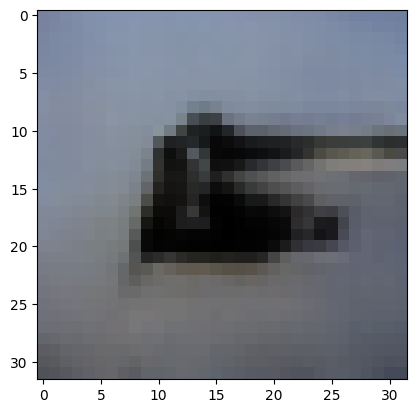

1/1 [==============================] - 0s 69ms/step
Ship


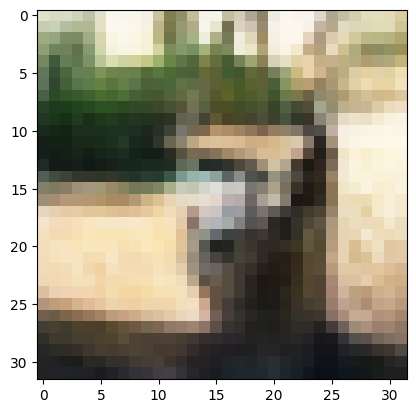

1/1 [==============================] - 0s 31ms/step
Ship


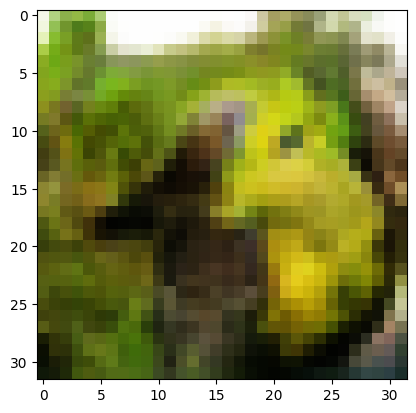

1/1 [==============================] - 0s 38ms/step
Bird


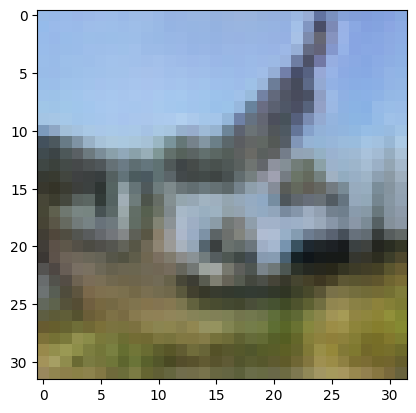

1/1 [==============================] - 0s 37ms/step
Airplane


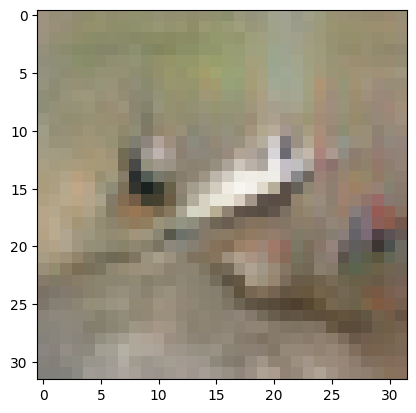

1/1 [==============================] - 0s 36ms/step
Bird


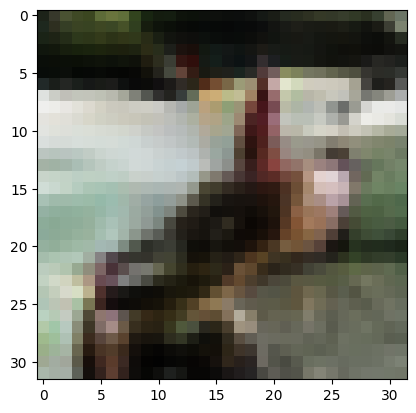

1/1 [==============================] - 0s 44ms/step
Horse


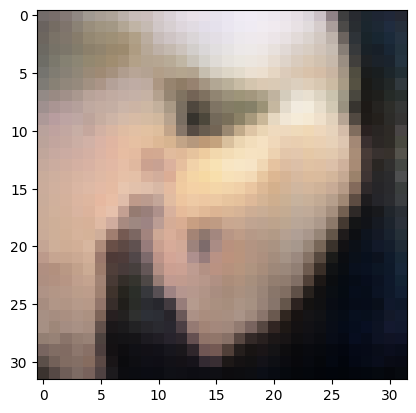

1/1 [==============================] - 0s 34ms/step
Cat


In [45]:
#Testing the fake pictures
#We load the fitted CIFAR10 classification model and
#see what classes are predicted by the GAN generated images for the first image of the ten rows
import numpy as np
class_names =['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
cifar10_model = load_model('final_model.h5')
pyplot.imshow(X[0, :, :])
pyplot.show()
#Here we show the actual predicted class values for the ten possible categories.
print(cifar10_model.predict(X[0, :, :].reshape((1,32,32,3))))
print(class_names[np.argmax(cifar10_model.predict(X[0, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[10, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[10, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[20, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[20, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[30, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[30, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[40, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[40, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[50, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[50, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[60, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[60, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[70, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[70, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[80, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[80, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[90, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[90, :, :].reshape((1,32,32,3))))])


1/1 [==============================] - 0s 29ms/step


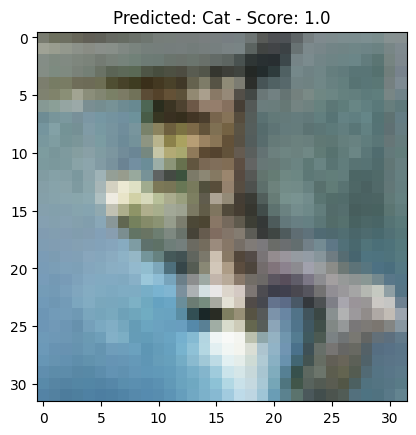

1/1 [==============================] - 0s 26ms/step


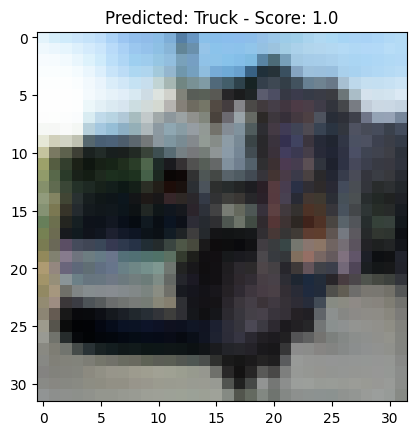

1/1 [==============================] - 0s 27ms/step


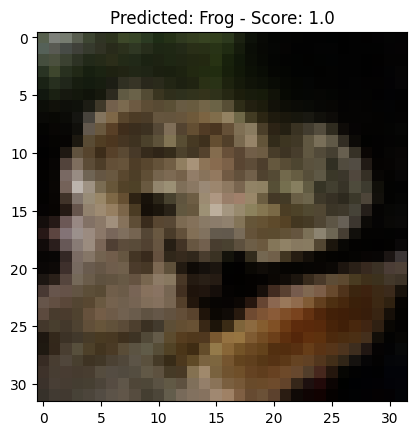

1/1 [==============================] - 0s 27ms/step


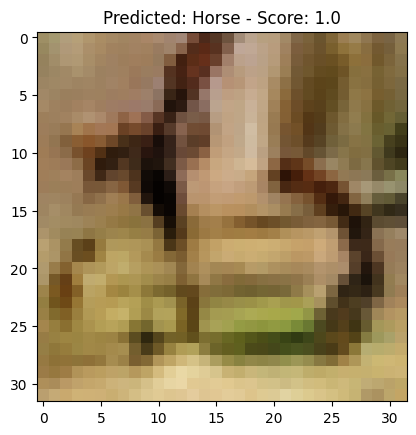

1/1 [==============================] - 0s 45ms/step


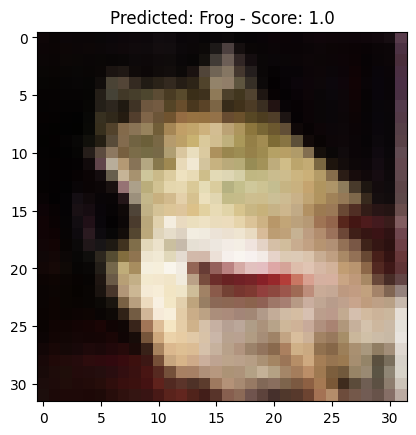

1/1 [==============================] - 0s 24ms/step


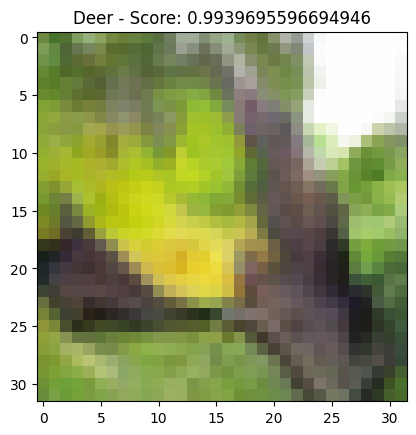

1/1 [==============================] - 0s 22ms/step


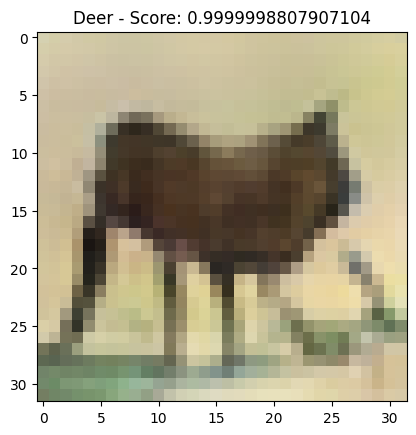

1/1 [==============================] - 0s 22ms/step


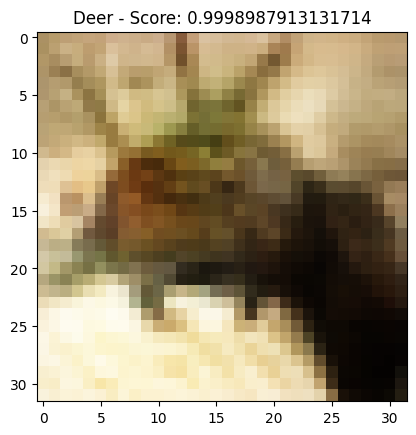

1/1 [==============================] - 0s 23ms/step


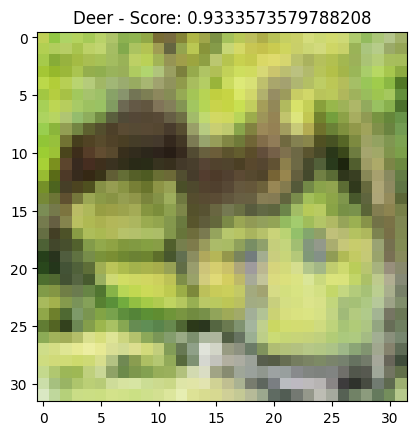

1/1 [==============================] - 0s 24ms/step


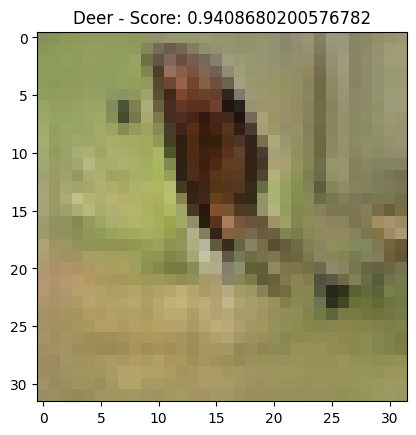

1/1 [==============================] - 0s 23ms/step


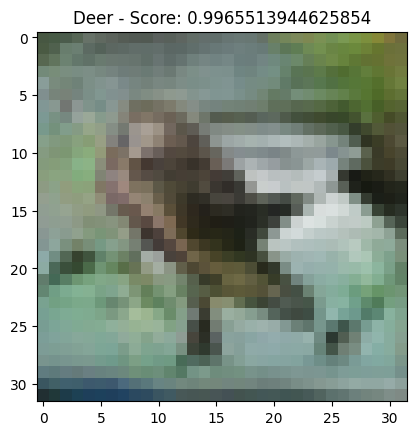

1/1 [==============================] - 0s 30ms/step


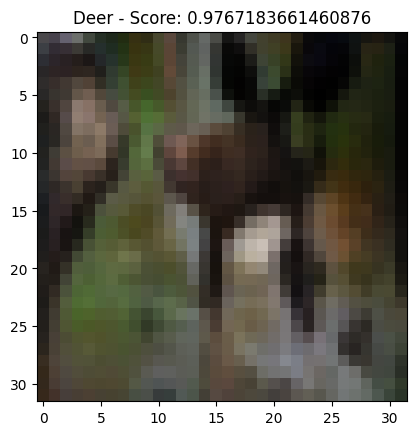

1/1 [==============================] - 0s 21ms/step


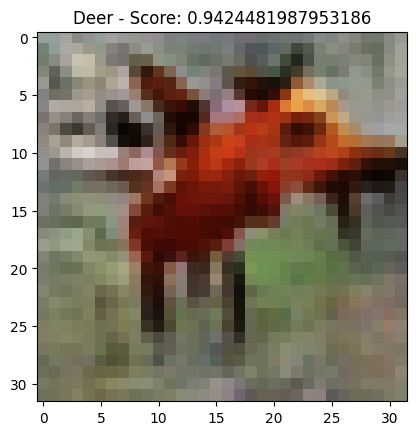

1/1 [==============================] - 0s 30ms/step


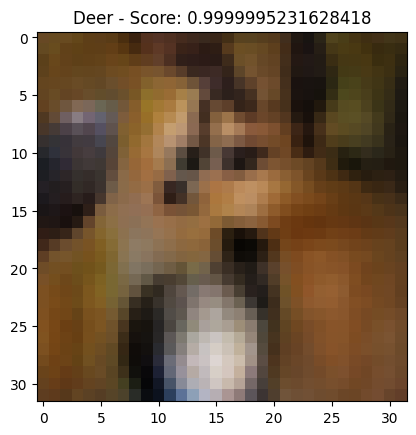

1/1 [==============================] - 0s 23ms/step


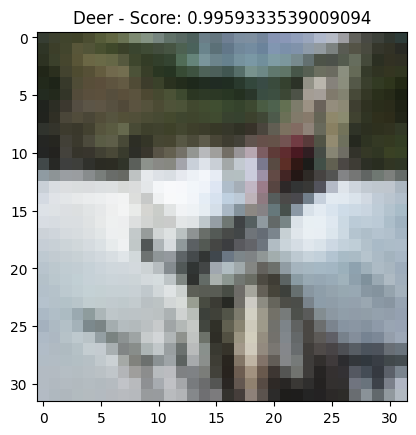

1/1 [==============================] - 0s 22ms/step


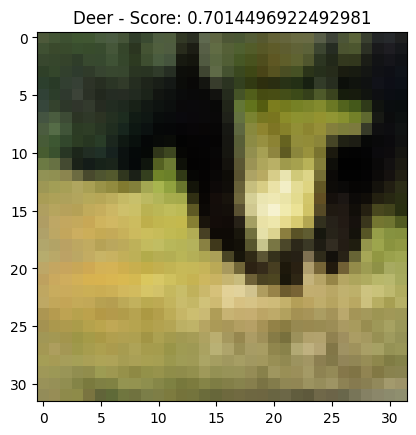

1/1 [==============================] - 0s 36ms/step


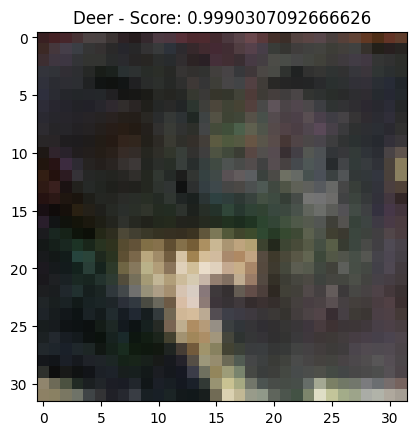

1/1 [==============================] - 0s 22ms/step


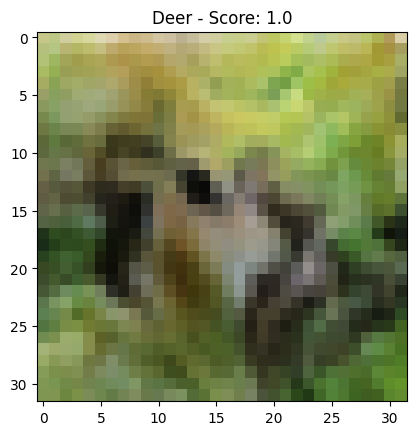

1/1 [==============================] - 0s 20ms/step


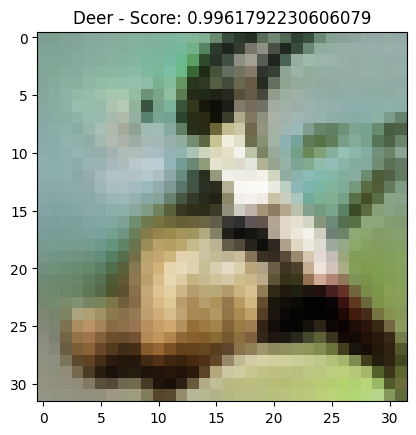

1/1 [==============================] - 0s 23ms/step


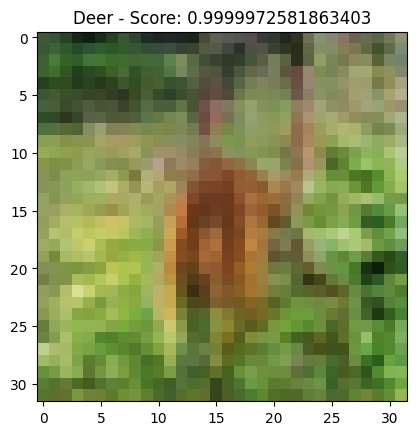

1/1 [==============================] - 0s 22ms/step


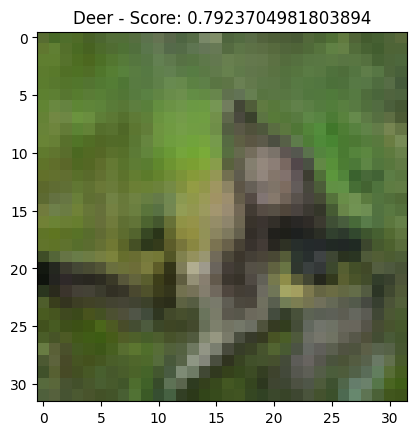

1/1 [==============================] - 0s 30ms/step


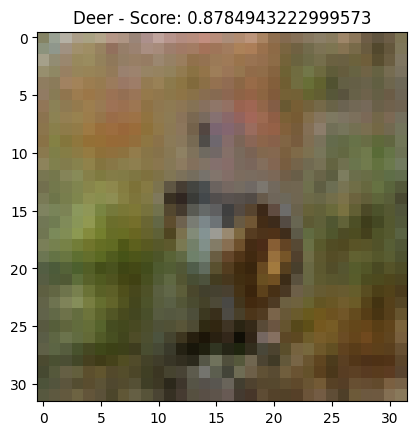

1/1 [==============================] - 0s 36ms/step


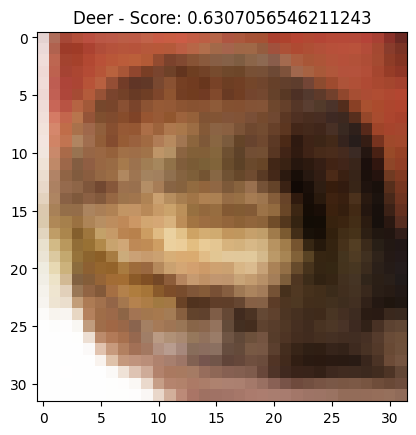

1/1 [==============================] - 0s 36ms/step


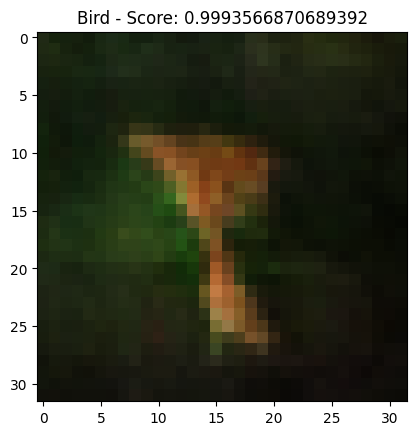

1/1 [==============================] - 0s 34ms/step


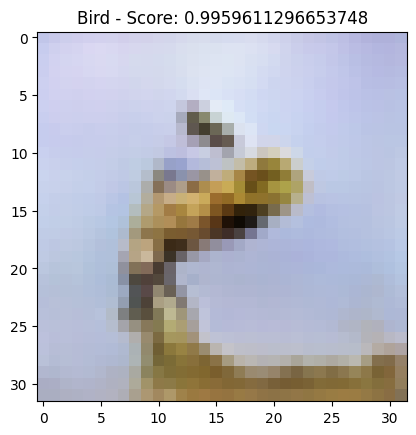

1/1 [==============================] - 0s 38ms/step


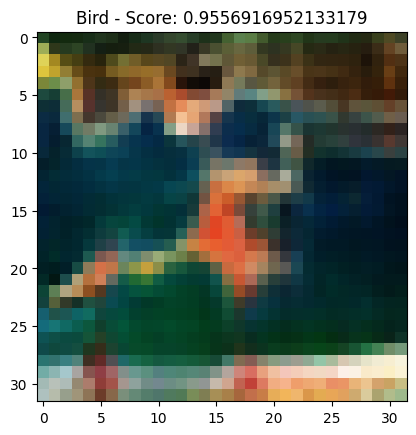

1/1 [==============================] - 0s 33ms/step


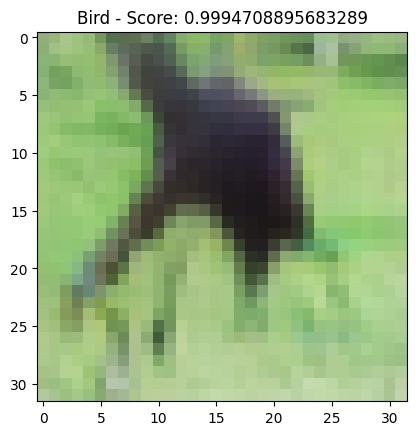

1/1 [==============================] - 0s 36ms/step


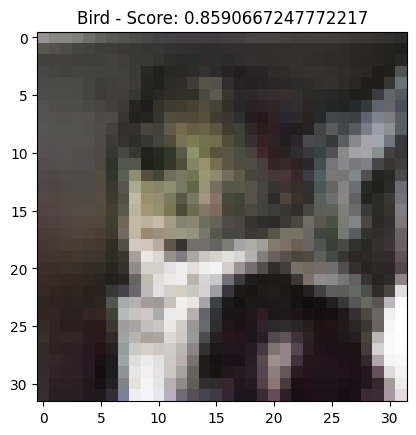

1/1 [==============================] - 0s 40ms/step


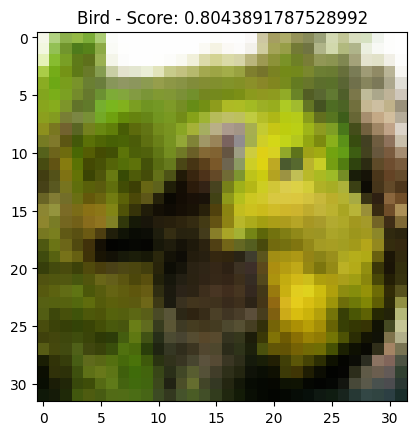

1/1 [==============================] - 0s 42ms/step


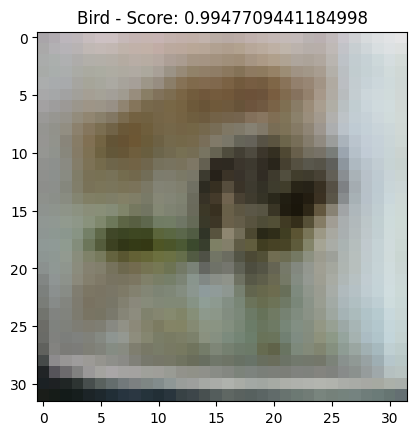

1/1 [==============================] - 0s 34ms/step


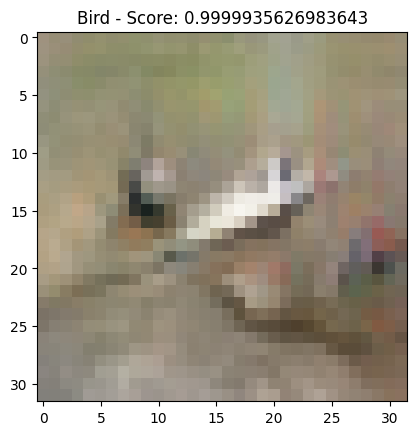

Deer: Min = 0.6307056546211243, Avg = 0.932109534740448, Max = 1.0
Bird: Min = 0.8043891787528992, Avg = 0.9510875940322876, Max = 0.9999935626983643
1/1 [==============================] - 0s 26ms/step


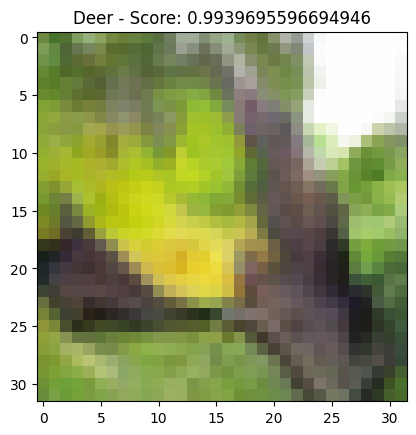

1/1 [==============================] - 0s 26ms/step


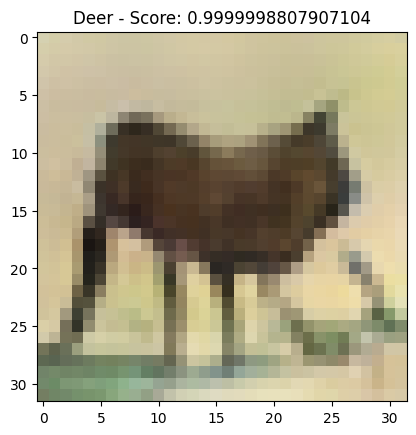

1/1 [==============================] - 0s 29ms/step


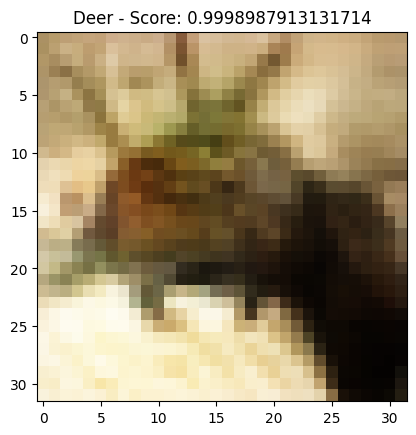

1/1 [==============================] - 0s 25ms/step


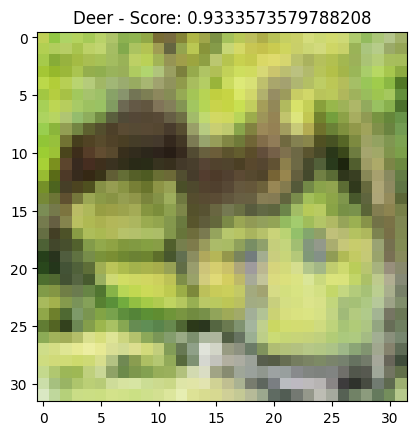

1/1 [==============================] - 0s 36ms/step


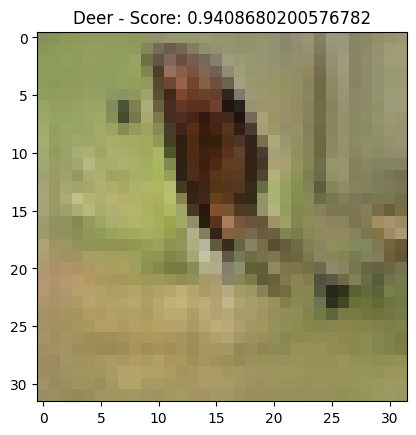

1/1 [==============================] - 0s 35ms/step


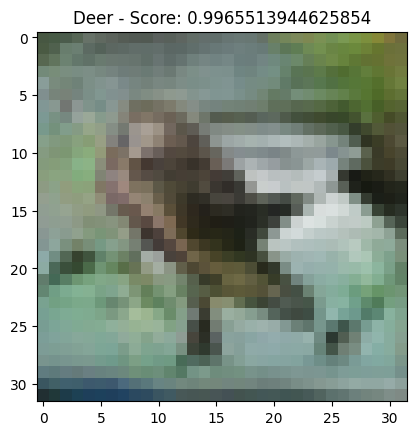

1/1 [==============================] - 0s 33ms/step


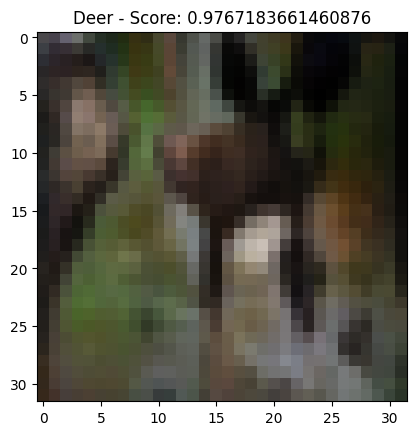

1/1 [==============================] - 0s 22ms/step


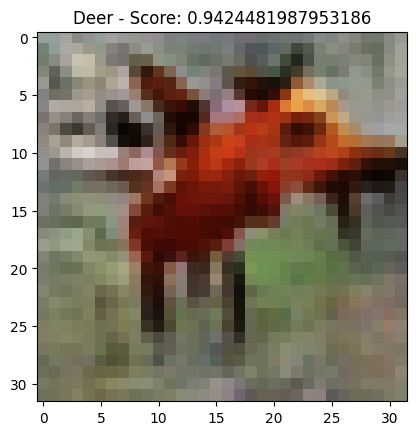

1/1 [==============================] - 0s 21ms/step


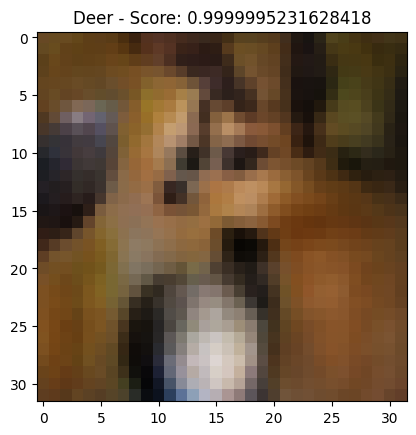

1/1 [==============================] - 0s 21ms/step


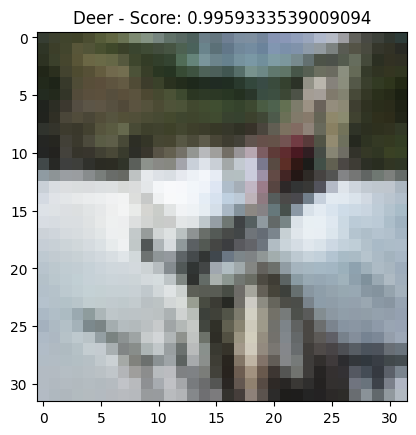

1/1 [==============================] - 0s 22ms/step


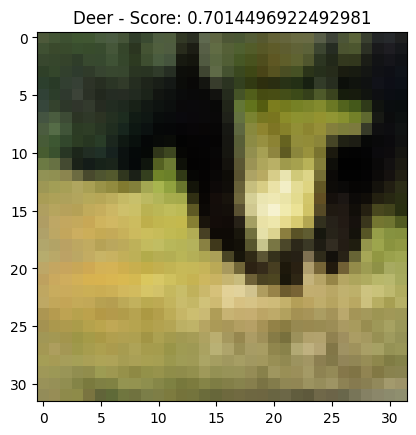

1/1 [==============================] - 0s 24ms/step


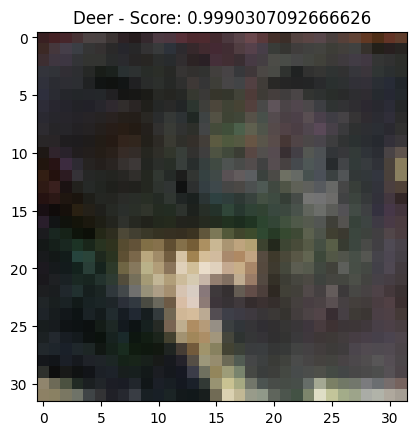

1/1 [==============================] - 0s 22ms/step


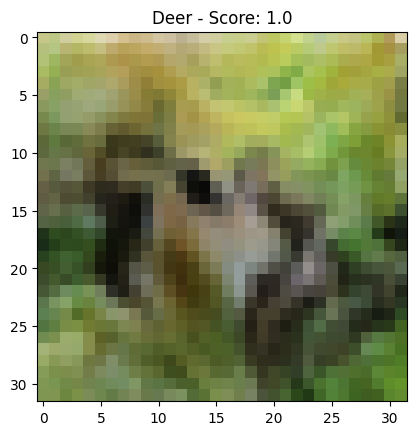

1/1 [==============================] - 0s 23ms/step


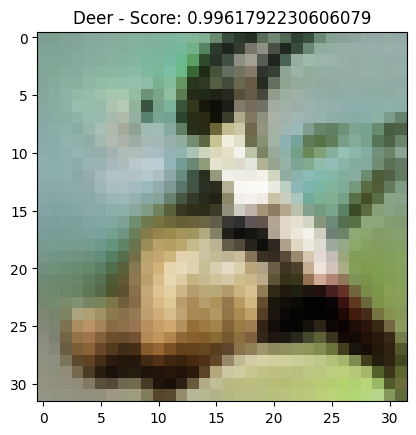

1/1 [==============================] - 0s 23ms/step


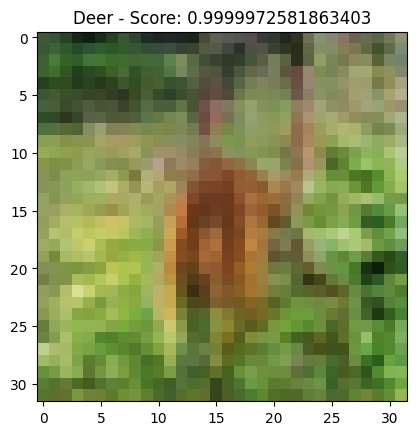

1/1 [==============================] - 0s 26ms/step


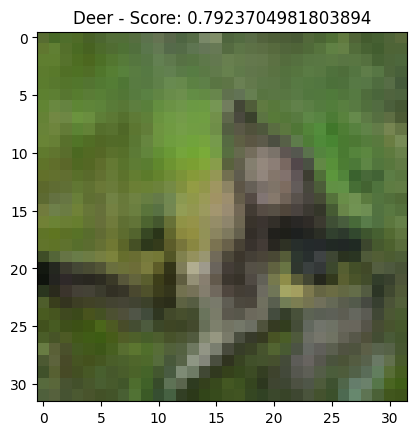

1/1 [==============================] - 0s 22ms/step


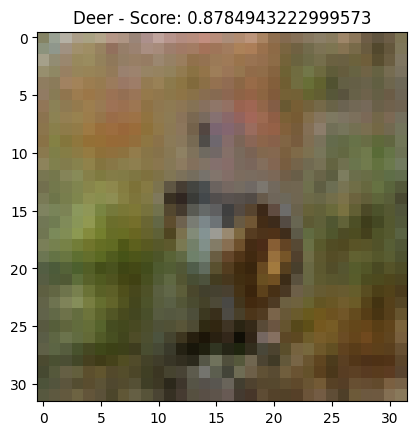

1/1 [==============================] - 0s 22ms/step


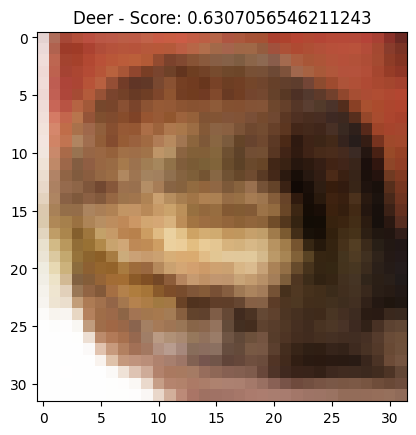

1/1 [==============================] - 0s 23ms/step


In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved models (final model and generator model)
cifar10_model = load_model('final_model.h5')

# The class names from the CIFAR-10 dataset
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# 1. Select top 5 'most real' images based on class confidence score
top_5_indices = []
top_5_scores = []
for i in range(100):
    image = X[i]
    reshaped_image = image.reshape((1, 32, 32, 3))
    prediction = cifar10_model.predict(reshaped_image)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    score = np.max(prediction)
    if len(top_5_indices) < 5:
        top_5_indices.append(i)
        top_5_scores.append(score)
    else:
        min_index = np.argmin(top_5_scores)
        if score > top_5_scores[min_index]:
            top_5_indices[min_index] = i
            top_5_scores[min_index] = score

# Display the top 5 images with their predicted classes and confidence scores
for index in top_5_indices:
    plt.imshow(X[index])
    plt.title(f'Predicted: {class_names[np.argmax(cifar10_model.predict(X[index].reshape((1, 32, 32, 3))))]} - Score: {np.max(cifar10_model.predict(X[index].reshape((1, 32, 32, 3))))}')
    plt.show()

# 2. Select and plot all instances of 'Deer' and 'Bird'
deer_indices = []
bird_indices = []
deer_scores = []
bird_scores = []
for i in range(100):
    prediction = cifar10_model.predict(X[i].reshape((1, 32, 32, 3)))
    predicted_class_index = np.argmax(prediction)
    if class_names[predicted_class_index] == 'Deer':
        deer_indices.append(i)
        deer_scores.append(np.max(prediction))
    elif class_names[predicted_class_index] == 'Bird':
        bird_indices.append(i)
        bird_scores.append(np.max(prediction))

# Plot all Deer images
for index in deer_indices:
    plt.imshow(X[index])
    plt.title(f'Deer - Score: {np.max(cifar10_model.predict(X[index].reshape((1, 32, 32, 3))))}')
    plt.show()

# Plot all Bird images
for index in bird_indices:
    plt.imshow(X[index])
    plt.title(f'Bird - Score: {np.max(cifar10_model.predict(X[index].reshape((1, 32, 32, 3))))}')
    plt.show()

# Compute the min, avg, max class values for Deer and Bird
deer_min, deer_avg, deer_max = np.min(deer_scores), np.mean(deer_scores), np.max(deer_scores)
bird_min, bird_avg, bird_max = np.min(bird_scores), np.mean(bird_scores), np.max(bird_scores)
print(f'Deer: Min = {deer_min}, Avg = {deer_avg}, Max = {deer_max}')
print(f'Bird: Min = {bird_min}, Avg = {bird_avg}, Max = {bird_max}')

# 3. Select and plot all class instances that have the highest average class value
class_scores = {name: [] for name in class_names}
for i in range(100):
    prediction = cifar10_model.predict(X[i].reshape((1, 32, 32, 3)))
    for j, class_name in enumerate(class_names):
        class_scores[class_name].append(prediction[0][j])

# Compute the average for each class
class_avg_scores = {class_name: np.mean(scores) for class_name, scores in class_scores.items()}

# Find the class with the highest average score
highest_avg_class = max(class_avg_scores, key=class_avg_scores.get)

# Plot all images that belong to this class
for i in range(100):
    prediction = cifar10_model.predict(X[i].reshape((1, 32, 32, 3)))
    predicted_class_index = np.argmax(prediction)
    if class_names[predicted_class_index] == highest_avg_class:
        plt.imshow(X[i])
        plt.title(f'{highest_avg_class} - Score: {np.max(prediction)}')
        plt.show()
